In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

from ctapipe.io.lsteventsource import LSTEventSource
from ctapipe.io import EventSeeker        

from calib_drs4 import LSTR1Calibrator, interpolate_spike_A, get_first_capacitor, int64, ped_time

In [3]:
#calib = LSTR1Calibrator(pedestal_path="data/pedestal_mirca_0005_0000_all_events.dat")
calib = LSTR1Calibrator(pedestal_path="data/pedestal_Run00060000.dat")

In [9]:
path_to_data_dir = "/home/pawel1/Pulpit/Astrophysics/CTA/dragon/data/dane_lst"
file_path_list = [path_to_data_dir + "/20180919/Mirca-1.Run0005.0000.fits.fz",
                  path_to_data_dir + "/20180919/Mirca-1.Run0005.0003.fits.fz",
                  path_to_data_dir + "/20180705/Date20180705.0010.fits.fz",
                  path_to_data_dir + "/20180919/Mirca-1.Run0006.0051.fits.fz"]

size4drs = 4096
roisize = 40
high_gain = 0
low_gain = 1
N_clus = 265
N_pix = 7

fc_old_array = np.zeros((N_clus, 2, 8))
fc_new_array = np.zeros((N_clus, 2, 8))

last_time_array = np.zeros((N_clus, 2, 7, 4096))

nr_of_events = 5
reader = LSTEventSource(input_url=file_path_list[3])
seeker = EventSeeker(reader)
event = seeker[0:nr_of_events]

for i, ev in enumerate(event):
    calib.calibrate(ev) 
    
    for nr_clus in range(0, N_clus):
        fc_old_array[nr_clus, :, :] = fc_new_array[nr_clus, :, :]
        fc_new_array[nr_clus, :, :] = get_first_capacitor(ev, nr_clus)
        fc_old = fc_old_array[nr_clus, :, :]
        fc_new = fc_new_array[nr_clus, :, :]

        #time lapse correction
        EVB = ev.lst.tel[0].evt.counters
        time_now = int64(EVB[14+(nr_clus*22) : 22+(nr_clus*22)])
        for gain in range(0, 2):
            for pixel in range(0, N_pix):
                for k in range(0, 40):
                    posads = int((k + fc_new[gain, pixel]) % size4drs)
                    if last_time_array[nr_clus, gain, pixel, posads] > 0:
                        time_diff = time_now - last_time_array[nr_clus, gain, pixel, posads]
                        val = ev.r1.tel[0].waveform[gain, pixel + nr_clus*7, k] - ped_time(time_diff/(133.e3))
                        ev.r1.tel[0].waveform[gain, pixel + nr_clus*7, k] = val
                    if (k < 39):
                        last_time_array[nr_clus, gain, pixel, posads] = time_now
                        
                        
                for k in range(0, 4):
                    abspos = int(1024 - roisize-2 - fc_old[gain, pixel]+ k*1024 +size4drs)
                    pos = int((abspos - fc_new[gain, pixel] + size4drs)%size4drs)        
                    if (pos > 2 and pos < 38):
                        interpolate_spike_A(ev, gain, pos, pixel, nr_clus) 
                        
                    abspos = int( roisize-2 + fc_old[gain, pixel]+ k*1024)
                    pos = int((abspos - fc_new[gain, pixel] + size4drs)%size4drs)        
                    if (pos > 2 and pos < 38):        
                        interpolate_spike_A(ev, gain, pos, pixel, nr_clus) 
                
                    
                spike_b_pos = int((fc_old[gain, pixel] - 1 - fc_new[gain, pixel] + 2*size4drs)%size4drs)
                if spike_b_pos < roisize-1:    
                    samples = ev.r1.tel[0].waveform[gain, pixel + nr_clus * 7, :] 
                    value = 0.5 * (samples[spike_b_pos - 1] + samples[spike_b_pos + 1])
                    ev.r1.tel[0].waveform[gain, pixel + nr_clus * 7, spike_b_pos] = value
                    

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/protozfits/__init__.py:56: UserWarning:         Multiple open zfits files at the same time are not supported.
        Reading from mutliple open tables at the same time will reset these
        tables continously and you will read always the same events.
        
  ''')


In [5]:
from plot_drs4_functions import plot_waveform

event id =  307582


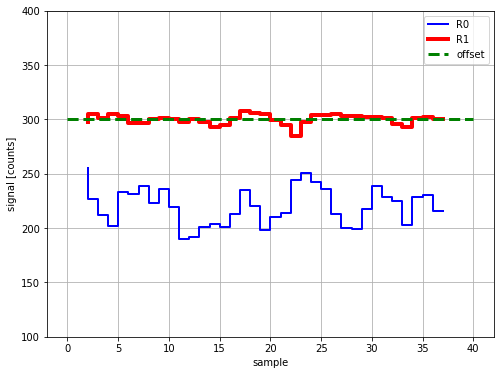

event id =  307583


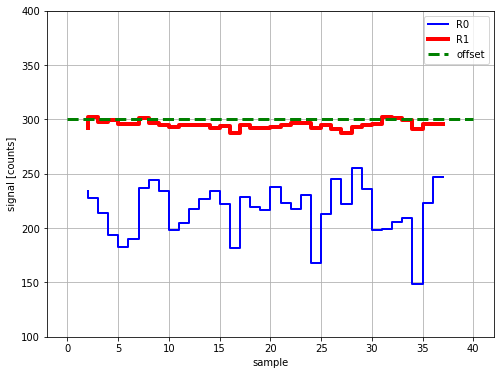

event id =  307584


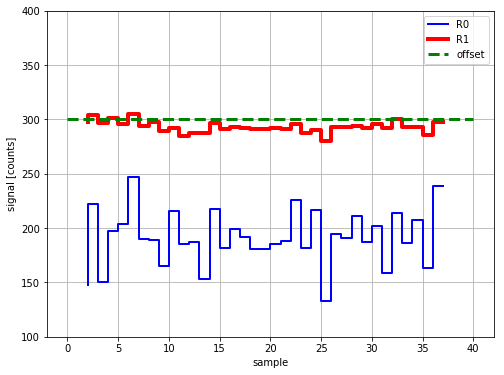

event id =  307585


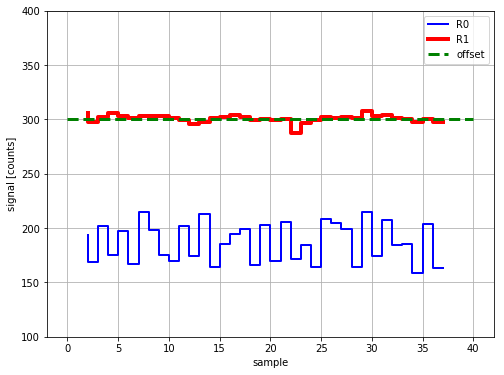

event id =  307586


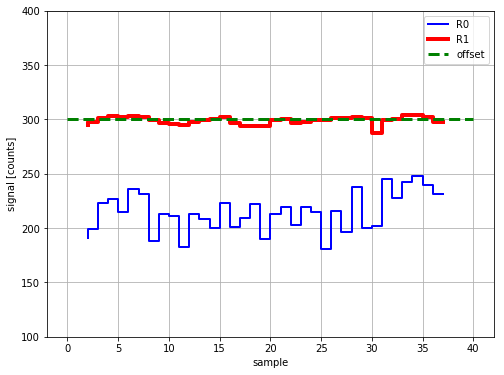

In [10]:
for i, ev in enumerate(event):
    print("event id = ", ev.r0.event_id)  
    plot_waveform(ev, gain=1, nr_clus=15, pixel=0, ylim=[100, 400]) 